## <font color='purple'> Assignment 04 - Transfer Learning and Bounding Boxes and YOLOV8

<font color='purple'> Follow the steps in YOLOV8 and attach a screenshot of object detection

Windows: https://medium.com/@pat.x.guillen/a-step-by-step-guide-to-running-yolov8-on-windows-122cb586b567Links to an external site.

Mac: https://pysource.com/2023/03/28/object-detection-with-yolo-v8-on-mac-m1/Links to an external site.

https://universe.roboflow.com/pxrksuhn/aihub-aizqc/dataset/1#

Use the dataset mentioned above.

### <font color='blue'> Object Detection using Detectron 2

<font color='blue'> Install relevant dependencies

In [1]:
!pip install torchvision torch pycocotools roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


<font color='blue'> Install Detectron 2 using Github Repo

In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vjw_onru
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vjw_onru
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

<font color='blue'> Import Relevant Libraries

In [3]:
import os
import shutil
import cv2
import glob
import random
import matplotlib.pyplot as plt
from roboflow import Roboflow
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

<font color='blue'> Check for Dataset directory. Remove the directory if it already exists

In [4]:
dir_path = "aiHub-1"

for root, dirs, files in os.walk(dir_path):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        shutil.rmtree(os.path.join(root, name))

if os.path.exists(dir_path):
  if not os.listdir(dir_path):
      os.rmdir(dir_path)
      print(f"Directory '{dir_path}' deleted successfully.")
  else:
      print(f"Directory '{dir_path}' is not empty.")
else:
  print(f"Directory '{dir_path}' does not exist.")

Directory 'aiHub-1' does not exist.


<font color='blue'> Download the dataset in COCO format from Roboflow

In [5]:
rf = Roboflow(api_key="nKPPYp27X19mLl1Nqolp")
project = rf.workspace("pxrksuhn").project("aihub-aizqc")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to aiHub-1 in coco:: 100%|██████████| 619/619 [00:00<00:00, 2588.44it/s]


<font color='blue'> Register the Dataset directories with Detectron 2 for training and evaluation

In [6]:
current_working_directory = os.getcwd()

train_images_path = os.path.join(current_working_directory, "aiHub-1/train")
train_annotations_path = os.path.join(train_images_path, "_annotations.coco.json")

val_images_path = os.path.join(current_working_directory, "aiHub-1/valid")
val_annotations_path = os.path.join(val_images_path, "_annotations.coco.json")

test_images_path = os.path.join(current_working_directory, "aiHub-1/test")
test_annotations_path = os.path.join(test_images_path, "_annotations.coco.json")

register_coco_instances("detectron_dataset_train", {}, train_annotations_path, train_images_path)

register_coco_instances("detectron_dataset_valid", {}, val_annotations_path, val_images_path)

register_coco_instances("detectron_dataset_test", {}, test_annotations_path, test_images_path)

my_dataset_train_metadata = MetadataCatalog.get("detectron_dataset_train")
dataset_dicts = DatasetCatalog.get("detectron_dataset_train")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



<font color='blue'> Visualize the train dataset to check images with labels

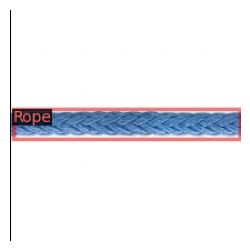

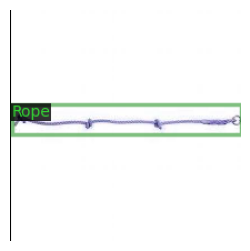

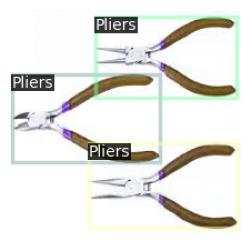

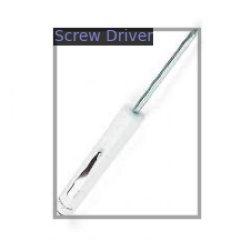

In [7]:
for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    plt.figure(figsize=(3, 3))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

<font color='blue'> <b> Setup Detectron Configuration for training the model </b> </br>
<font color='Green'> The task is very resource intensive, in absence of a GPU, I have forced the CPU mode and increased the learning rate. I have also reduced the number of iterations to allow quick training. With availability of a GPU, this can be increased for better results

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.DATASETS.TRAIN = ("detectron_dataset_train",)
cfg.DATASETS.TEST = ("detectron_dataset_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.DEVICE = "cpu" # Forcing CPU usage, we can comment this if GPU is available
cfg.SOLVER.BASE_LR = 0.00025 # We can reduce this for better results
cfg.SOLVER.MAX_ITER = 1500 # We can increase this for better results
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 125
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

cfg.OUTPUT_DIR = "./aiHub-1/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

<font color='blue'> With Detectron2, the default training setup does not automatically validate the trained model against a validation dataset. Due to this we need to define a custom trainer to allow this.

In [9]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("./aiHub-1/coco_eval", exist_ok=True)
        output_folder = "./aiHub-1/coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

<font color='blue'> <b> Train the model based on the defined configuration

In [10]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/28 20:19:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_f97cb7.pkl: 136MB [00:01, 73.9MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[09/28 20:19:31 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


[09/28 20:19:48 d2.utils.events]:  eta: 0:12:16  iter: 19  total_loss: 2.702  loss_cls: 1.83  loss_box_reg: 0.4696  loss_rpn_cls: 0.2437  loss_rpn_loc: 0.1413    time: 0.5123  last_time: 0.4810  data_time: 0.0455  last_data_time: 0.0224   lr: 4.9953e-06  max_mem: 1739M
[09/28 20:20:01 d2.utils.events]:  eta: 0:11:18  iter: 39  total_loss: 2.496  loss_cls: 1.691  loss_box_reg: 0.5423  loss_rpn_cls: 0.1114  loss_rpn_loc: 0.1173    time: 0.4830  last_time: 0.4417  data_time: 0.0120  last_data_time: 0.0131   lr: 9.9902e-06  max_mem: 1741M
[09/28 20:20:10 d2.utils.events]:  eta: 0:11:04  iter: 59  total_loss: 2.258  loss_cls: 1.365  loss_box_reg: 0.631  loss_rpn_cls: 0.1227  loss_rpn_loc: 0.1398    time: 0.4705  last_time: 0.4706  data_time: 0.0108  last_data_time: 0.0262   lr: 1.4985e-05  max_mem: 1741M
[09/28 20:20:19 d2.utils.events]:  eta: 0:10:39  iter: 79  total_loss: 1.794  loss_cls: 0.9379  loss_box_reg: 0.595  loss_rpn_cls: 0.1027  loss_rpn_loc: 0.1018    time: 0.4663  last_time: 0

<font color='blue'> We run the same evaluation procedure next on the test set. We will also run inference on the test data.

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("detectron_dataset_test", cfg, False, output_dir="./aiHub-1/output/")
val_loader = build_detection_test_loader(cfg, "detectron_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/28 20:31:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./aiHub-1/output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [09/28 20:31:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [09/28 20:31:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 20:31:52 d2.data.datasets.coco]: Loaded 26 images in COCO format from /content/aiHub-1/test/_annotations.coco.json
[09/28 20:31:52 d2.data.build]: Distribution of instances among all 7 categories:
|  category  | #instances   |   category   | #instances   |  category  | #instances   |
|:----------:|:-------------|:------------:|:-------------|:----------:|:-------------|
|   aiHub    | 0            |    Hammer    | 6            |   Pliers   | 4            |
|    Rope    | 5            | Screw Driver | 12           |  Tool Box  | 4            |
|   Wrench   | 14           |              |              |            |              |
|   total    | 45           |              |    

OrderedDict([('bbox',
              {'AP': 54.40804883150544,
               'AP50': 79.95576844867963,
               'AP75': 57.18215781477897,
               'APs': nan,
               'APm': 35.85808580858085,
               'APl': 57.30443253407829,
               'AP-aiHub': nan,
               'AP-Hammer': 35.178333622835964,
               'AP-Pliers': 83.16831683168317,
               'AP-Rope': 78.53465346534654,
               'AP-Screw Driver': 35.21024673895962,
               'AP-Tool Box': 48.33333333333333,
               'AP-Wrench': 46.023408996874025})])

<font color='blue'> Visualizing the final results on the test dataset.

[09/28 20:31:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./aiHub-1/output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


./aiHub-1/test/000062_jpg.rf.bc6e3a61e0c667ad24c8cc31e4ce7f88.jpg


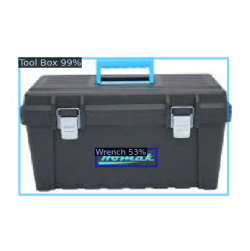

./aiHub-1/test/000046_jpg.rf.5c4d91cd4e915e17715d7e3000a8aaa0.jpg


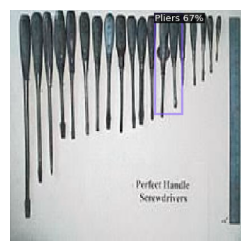

./aiHub-1/test/000071_jpg.rf.826787eb434fcd8405216d8f429a5e52.jpg


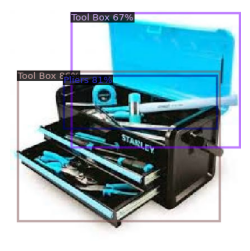

./aiHub-1/test/000023_jpg.rf.d8c03e61b1a685979e5068df93d85e1c.jpg


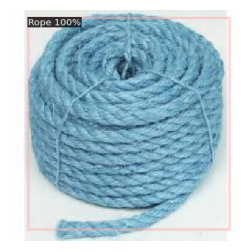

./aiHub-1/test/000041_jpg.rf.d9d28dd00679e897eb2d72eb31ead916.jpg


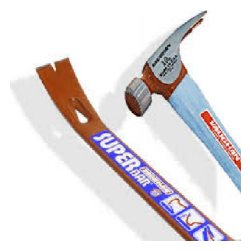

./aiHub-1/test/000008_jpg.rf.2ec3ae0f45aad59174c2139b1ab2c04c.jpg


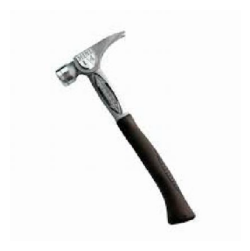

./aiHub-1/test/000017_jpg.rf.dac6266dcf1b636cbbf68b83d5ef9e09.jpg


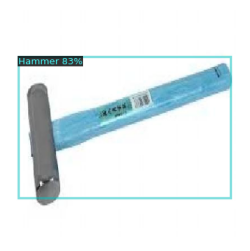

./aiHub-1/test/000039_jpg.rf.9de826dbfded6ed11ea49af657b7d214.jpg


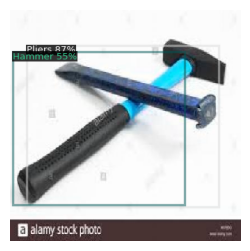

./aiHub-1/test/000008_jpg.rf.92c9368abc042a5793ad34a08e16ccc7.jpg


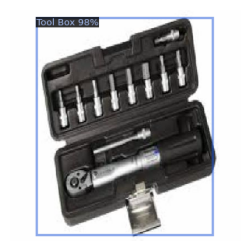

./aiHub-1/test/000047_jpg.rf.17eca05dd409201e88234dd87049ee2b.jpg


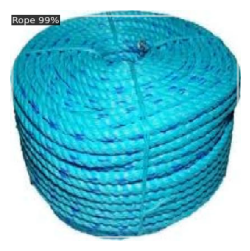

./aiHub-1/test/000008_jpg.rf.1c9fac7314f7c395684d767630d8435a.jpg


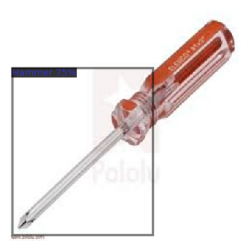

./aiHub-1/test/000032_jpg.rf.182bfa574334d853028012724877310c.jpg


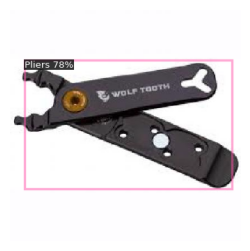

./aiHub-1/test/000050_jpg.rf.95515f7ae6e2741effc8c32fa4bb293f.jpg


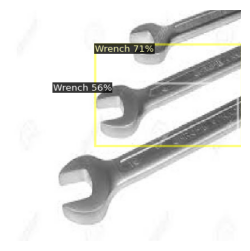

./aiHub-1/test/000038_jpg.rf.8518014485dcea328b7e1d902a28bee3.jpg


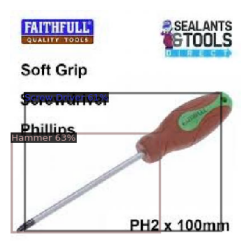

./aiHub-1/test/000007_jpg.rf.4fea82fe27d57392d3bea4fee5d955f2.jpg


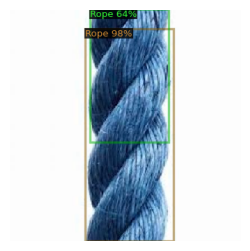

./aiHub-1/test/000026_jpg.rf.d510b7c6f0f3c2a9bc71bc7dad0db549.jpg


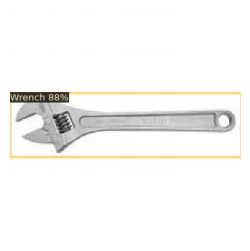

./aiHub-1/test/000042_jpg.rf.ef9d67fcb8350e314955c529a47e1950.jpg


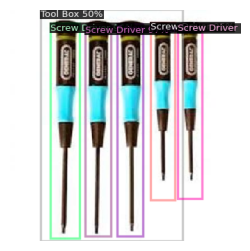

./aiHub-1/test/000002_jpg.rf.3fe959f5175a87e988c5a5f69d779fcd.jpg


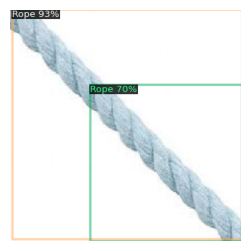

./aiHub-1/test/000093_jpg.rf.b23bcde15236ae083bbb6bfdad2b07b9.jpg


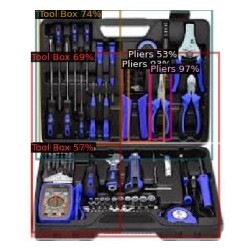

./aiHub-1/test/000023_jpg.rf.535ac4439de275270923da6cf2fe1430.jpg


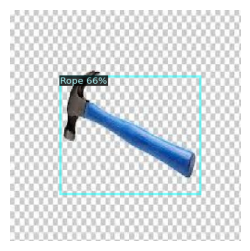

./aiHub-1/test/000048_jpg.rf.7bc00474d6c17498c2f7aee8dac3cdca.jpg


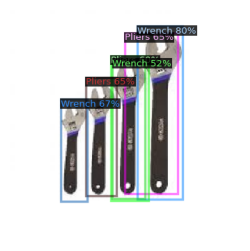

./aiHub-1/test/000016_jpg.rf.49caa35a4fa6c64f926aa19207624c03.jpg


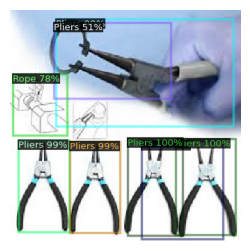

./aiHub-1/test/000027_jpg.rf.da984e1ecb4a2f3ef9c7711641d13fb8.jpg


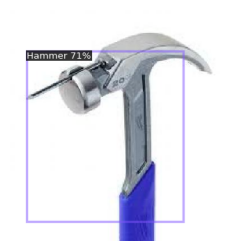

./aiHub-1/test/000013_jpg.rf.e379ee03d9b72a5439ae32dbb693de3a.jpg


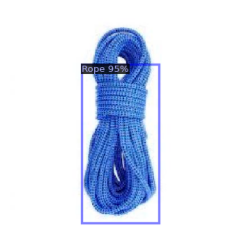

./aiHub-1/test/000007_jpg.rf.60dbc245bf7d0b7c5455cf7333f99164.jpg


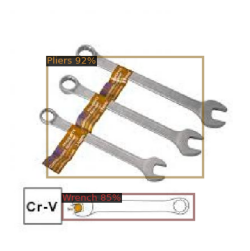

./aiHub-1/test/000074_jpg.rf.05d94894535f90f7ef44cbbfa7314015.jpg


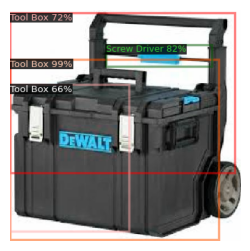

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("detectron_dataset_test",)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("detectron_dataset_test")

for imageName in glob.glob('./aiHub-1/test/*_jpg.rf.*.jpg'):
    print(imageName)
    im = cv2.imread(imageName)
    outputs = predictor(im)

    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(3, 3))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

## <font color='purple'> Thank You!!